In [340]:
# Udacity course DataScience
# Project I "How to breakt into the field?"
# Analysis on Seattle AirBnB data

# Import needed libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load Airbnb data into dataframe
df_calendar = pd.read_csv('./Seattle/calendar.csv')
df_listings = pd.read_csv('./Seattle/listings.csv')
df_reviews = pd.read_csv('./Seattle/reviews.csv')

# Show head to get a feeling of the data
#df_calendar.head()
df_listings.head()
#df_reviews.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [341]:
# Price column contains NaN values for unavailable listings. Fill them with 0.
df_calendar['price'].fillna(0, inplace=True)

# Date column is a string value. Convert them to Python datetime for easy access via dt
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

# Create new columns for year, month, day
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day

# Remove "$" from price column and convert it to float
df_calendar['price'].replace('\$|,','', regex=True, inplace=True)
df_calendar['price'] = df_calendar['price'].astype('float')

# Filter only for available listings
df_available_listings = df_calendar[df_calendar['available'] == 't']

#Calculate avg price per month for available listings
arr_avg_price_month = []
for month in range(1,13):
    arr_avg_price_month.append(df_available_listings[df_available_listings['month'] == month]['price'].mean())

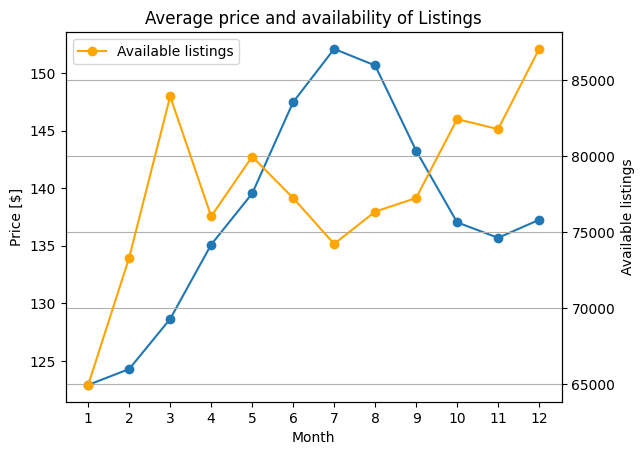

In [342]:
# Plot data to answer Question Nr. 1
fig, ax = plt.subplots()
ax.plot(range(1,1+len(arr_avg_price_month)), arr_avg_price_month, label='Average price', marker='o')

ax.set_xlabel('Month')
ax.set_xticks(range(1,1+len(arr_avg_price_month)))
ax.set_ylabel('Price [$]')

ax2 = ax.twinx()
ax2.plot(df_available_listings['month'].value_counts().sort_index(), label='Available listings', marker='o', color='orange')
ax2.set_ylabel('Available listings')

plt.grid()
plt.title('Average price and availability of Listings')
plt.legend()
plt.show()

In [343]:
# Drop rows with missing price since we want to predict this feature
df_listings.dropna(subset=['price'], inplace=True)

# Drop any URL related column
url_list = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url','host_thumbnail_url', 
            'host_picture_url']
df_listings = df_listings.drop(url_list, axis=1)

# Convert dollar to float
df_listings['price'].replace('\$|,','', regex=True, inplace=True)
df_listings['price'] = df_listings['price'].astype('float')

df_listings['security_deposit'].replace('\$|,','', regex=True, inplace=True)
df_listings['security_deposit'] = df_listings['security_deposit'].astype('float')

df_listings['cleaning_fee'].replace('\$|,','', regex=True, inplace=True)
df_listings['cleaning_fee'] = df_listings['cleaning_fee'].astype('float')

df_listings['extra_people'].replace('\$|,','', regex=True, inplace=True)
df_listings['extra_people'] = df_listings['extra_people'].astype('float')

df_listings['monthly_price'].replace('\$|,','', regex=True, inplace=True)
df_listings['monthly_price'] = df_listings['monthly_price'].astype('float')

df_listings['weekly_price'].replace('\$|,','', regex=True, inplace=True)
df_listings['weekly_price'] = df_listings['weekly_price'].astype('float')

# Convert percent to float
df_listings['host_response_rate'].replace('\%|,','', regex=True, inplace=True)
df_listings['host_response_rate'] = df_listings['host_response_rate'].astype('float')

df_listings['host_acceptance_rate'].replace('\%|,','', regex=True, inplace=True)
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].astype('float')

# Split amenities
df_listings['amenities'] = df_listings['amenities'].apply(lambda x: x.replace('{','')
                                                              .replace('}','')
                                                              .replace('"','')
                                                              .replace(' ','_')
                                                              .replace(',',' ')
                                                              .split()
                                                             )
all_ame = []
for ame in df_listings.amenities:
    all_ame.extend(ame)

unique_ame = pd.unique(all_ame)

# Create matrix with length of df_listings & column names according to split amenities
zero_matrix = np.zeros((len(df_listings),len(unique_ame)))
dummies_ame = pd.DataFrame(zero_matrix,columns=unique_ame)

# Fill the matrix based on availability of amenities within a listing
for i,ame in enumerate(df_listings.amenities):
    indices = dummies_ame.columns.get_indexer(ame)
    dummies_ame.iloc[i,indices]=1

# Join the two dataframes
df_listings = df_listings.join(dummies_ame)

# Split host_verifications
df_listings['host_verifications'] = df_listings['host_verifications'].apply(lambda x: x.replace('{','')
                                                              .replace('}','')
                                                              .replace('"','')
                                                              .replace(' ','_')
                                                              .replace(',',' ')
                                                              .split()
                                                             )
all_host_vers = []
for host_vers in df_listings.host_verifications:
    all_host_vers.extend(host_vers)

unique_host_vers = pd.unique(all_host_vers)

# Create matrix with length of df_listings & column names according to split amenities
zero_matrix = np.zeros((len(df_listings),len(unique_host_vers)))
dummies_host_vers = pd.DataFrame(zero_matrix,columns=unique_host_vers)

# Fill the matrix based on availability of amenities within a listing
for i,host_vers in enumerate(df_listings.host_verifications):
    indices = dummies_host_vers.columns.get_indexer(host_vers)
    dummies_host_vers.iloc[i,indices]=1

# Join the two dataframes
df_listings = df_listings.join(dummies_host_vers)

# Drop columns which are weak correlated to price
weak_cols = df_listings.corr().columns[(np.abs(df_listings.corr()['price']) < 0.1)]
df_listings.drop(weak_cols, axis=1, inplace=True)


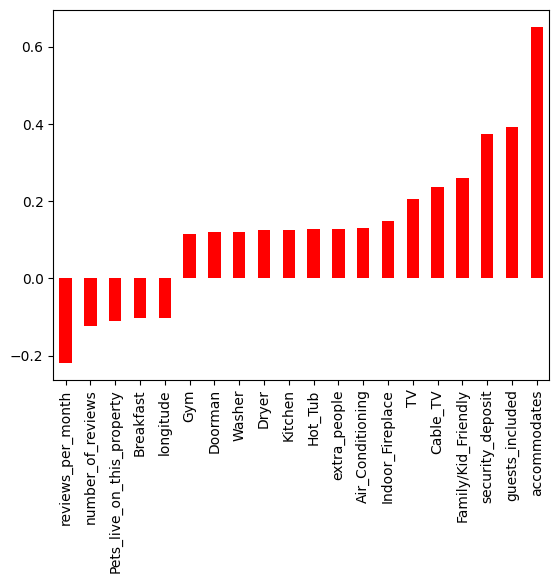

In [344]:
# Remove columns with high correlation to size of listing since this is a expected. We want to find other dependencies. Also weekly and monthly price is removed. Cleaning fee is also directly related to 
# the size of the listing and therefore removed.
remove_cols = ['bedrooms','beds','square_feet','bathrooms','weekly_price','monthly_price', 'cleaning_fee']
df_listings.drop(remove_cols, axis=1, inplace=True)

df_listings.corr()['price'].dropna().sort_values()[:-1].plot(kind='bar', color='red')
plt.show()

